## Welcome to Week 4, Day 4

This is the start of an AWESOME project! Really simple and very effective.

In [1]:
from typing import Annotated #for adding comming
from typing_extensions import TypedDict # for stategraph as replacement for Basemodel
from langgraph.graph import StateGraph, START # defining state graph
from langgraph.graph.message import add_messages # adding meta data
from dotenv import load_dotenv #ENV variable
from IPython.display import Image, display #show graph
import gradio as gr #UI
from langgraph.prebuilt import ToolNode, tools_condition #prebuilt tools from langraph could be playwright
import requests # API requests to pushover
import os #os
from langchain.agents import Tool #defining custom functionsas tool

from langchain_openai import ChatOpenAI # calling llm
from langgraph.checkpoint.memory import MemorySaver #memory saver

In [2]:
load_dotenv(override=True) #load_dotenve(override=True)

True

### Asynchronous LangGraph

To run a tool:  
Sync: `tool.run(inputs)`  
Async: `await tool.arun(inputs)`

To invoke the graph:  
Sync: `graph.invoke(state)`  
Async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

## Extra installation step - if you don't have Node and Playwright on your computer

Next, you need to install NodeJS and Playwright on your computer if you don't already have them. Please see instructions here:

[Node and Playwright setup](../setup/SETUP-node.md)

## And now - after Installing Playwright, a heads up for Windows PC Users:

While executing the next few cells, you might hit a problem with the Playwright browser raising a NotImplementedError.

This should work when we move to python modules, but it can cause problems in Windows in a notebook.

If you it this error and would like to run the notebook, you need to make a small change which seems quite hacky! You need to do this AFTER installing Playwright (prior cells)

1. Right click in `.venv` in the File Explorer on the left and select "Find in folder"
2. Search for `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())`  
3. That code should be found in a line of code in a file called `kernelapp.py`
4. Comment out the entire else clause that this line is a part of - see the fragment below. Be sure to have the "pass" statement after the ImportError line.
5. Restart the kernel by pressing the "Restart" button above

```python
        if sys.platform.startswith("win") and sys.version_info >= (3, 8):
            import asyncio
 
            try:
                from asyncio import WindowsProactorEventLoopPolicy, WindowsSelectorEventLoopPolicy
            except ImportError:
                pass
                # not affected
           # else:
            #    if type(asyncio.get_event_loop_policy()) is WindowsProactorEventLoopPolicy:
                    # WindowsProactorEventLoopPolicy is not compatible with tornado 6
                    # fallback to the pre-3.8 default of Selector
                    # asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())
```

Thank you to student Nicolas for finding this, and to Kalyan, Yaki, Zibin and Bhaskar for confirming that this worked for them! And to Vladislav for the extra pointers.

As an alternative, you can just move to a Python module (which we do anyway in Day 5)

In [5]:
# Introducing nest_asyncio
# Python async code only allows for one "event loop" processing aynchronous events.
# The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

import nest_asyncio
nest_asyncio.apply()

### The LangChain community

One of the remarkable things about LangChain is the rich community around it.

Check this out:


In [6]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [7]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ajay/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ajay/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ajay/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ajay/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ajay/.cache/ms-playwright/chromium-1181/chrome-linux/chrome> version=139.0.7258.5>
get_elements=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/ajay/.cache/ms-playwright/chro

In [8]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
#await navigate_tool.arun({"url": "https://www.cnn.com"})
await navigate_tool.arun({"url": "https://bbc.com"})
text = await extract_text_tool.arun({})

In [9]:
import textwrap
print(textwrap.fill(text))

BBC Home - Breaking News, World News, US News, Sports, Business,
Innovation, Climate, Culture, Travel, Video & Audio Skip to content
Advertisement Advertisement British Broadcasting Corporation Register
Sign In Home News Sport Business Innovation Culture Arts Travel Earth
Audio Video Live Home News Israel-Gaza War War in Ukraine US & Canada
UK UK Politics England N. Ireland N. Ireland Politics Scotland
Scotland Politics Wales Wales Politics Africa Asia China India
Australia Europe Latin America Middle East In Pictures BBC InDepth BBC
Verify Sport Business Executive Lounge Technology of Business Future
of Business Innovation Technology Science & Health Artificial
Intelligence AI v the Mind Culture Film & TV Music Art & Design Style
Books Entertainment News Arts Arts in Motion Travel Destinations
Africa Antarctica Asia Australia and Pacific Caribbean & Bermuda
Central America Europe Middle East North America South America World’s
Table Culture & Experiences Adventures The SpeciaList Eart

In [10]:
all_tools = tools + [tool_push]

In [11]:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


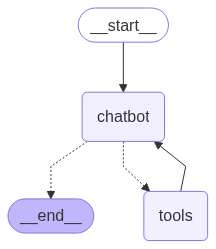

In [12]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "55"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

Exception in thread Thread-58 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/ajay/projects/udemy_agentic/agents/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ajay/projects/udemy_agentic/agents/.venv/lib/python3.12/site-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ajay/projects/udemy_agentic/agents/.venv/lib/python3.12/site-packages/nest_asyncio.py", line 26, in run
    loop = asyncio.get_event_loop()
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ajay/projects/udemy_agentic/agents/.venv/lib/python3.12/site-packages/nest_asyncio.py", line 40, in _get_event_loop
    loop = events.get_e

KeyboardInterrupt: 